In [1]:
import pandas as pd
import spacy
import pickle
from tqdm import tqdm
from gensim.corpora import Dictionary
from sklearn.utils import shuffle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nlp = spacy.load('en')
DATA_LIMIT = 1000

df = pd.read_csv('./imdb_master.csv', encoding='latin1')
df_neg = df[df['label'] == 'neg']
df_pos = df[df['label'] == 'pos']
df = pd.concat((df_pos[:DATA_LIMIT], df_neg[:DATA_LIMIT]))

def process_text(input_string, return_string=False, stem=False):
    text = nlp(u'' + input_string)
    if stem == True:
        text = [tok.lemma_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    else:
        text = [tok.lower_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    if return_string == True:
        return " ".join(text)
    return text

In [2]:
# Make this statement true to run from scratch [It takes time to process the text]
if 1 == 1:
    wordlist = []
    for i in tqdm(range(df.shape[0])):
        wordlist.append(process_text(df['review'].iloc[i]))
        
    with open('vocabulary.txt', 'wb') as vocabulary:
        pickle.dump(wordlist, vocabulary)
    vocabulary.close()

100%|██████████| 2000/2000 [01:57<00:00, 17.01it/s]


In [3]:
# Load vocabulary
wordlist = []
with open('vocabulary.txt', 'rb') as vocabulary:
    wordlist = pickle.load(vocabulary)

In [4]:
# Keeping track of frequency of a single token
frequency = defaultdict(int)
for text in wordlist:
    for token in text:
        frequency[token] += 1
        
# Apply Threshold to limit the vocabulary size, discarding the tokens which appeard number of times below the threshold limit 
FREQ_THRESHOLD = 5

thresholded_wordlist =  [[token for token in text if frequency[token] > FREQ_THRESHOLD]
          for text in wordlist]

# Create Dictionary based on the word list
dictionary = Dictionary(thresholded_wordlist)

# Number of tokens
print("Number of Tokens - {}".format(len(dictionary)))

Number of Tokens - 5464


![image](https://i.imgur.com/f1uzTDZ.png)

# TODO

* From the screenshot you can see the implementation of word-cooccurance matrix, based on the tokens from the dictionary, build a word-cooccurance matrix yourself which is $X$. Documentation of gensim [https://radimrehurek.com/gensim/corpora/dictionary.html]
* Apply SVD on $X$
* Reduce Dimension 

![dimen_reduc](https://i.imgur.com/lezB870.png)

* Here Richard is taking only top two dimensions of the vector $U$, recommended size is *50* for now.

![dimen_reduc_u](https://i.imgur.com/TA2Bmsq.png)

* Now we can get a fixed size vector for each word. 

* Try to plot something similar based on the given dataset. In class we will try to implement a logistic regression classifier that can classify positive and negative reviews

In [5]:
# creating word co-occurance matraix

l = len(dictionary)

X = np.zeros((l, l))

for text in thresholded_wordlist:
    
    ind = dictionary.doc2idx(text)
    
    for i in ind:
        for j in ind:            
            X[i, j] += 1

In [6]:
# computing SVD

U, S, Vh = np.linalg.svd(X, full_matrices = False)

np.save('U.npy', U)
np.save('S.npy', S)
np.save('Vh.npy', Vh)

In [7]:
# reducing dimension

U_reduced = U[:, :50]
S_reduced = S[:50]
Vh_reduced = Vh[:50, :]

np.save('U_reduced.npy', U_reduced)
np.save('S_reduced.npy', S_reduced)
np.save('Vh_reduced.npy', Vh_reduced)

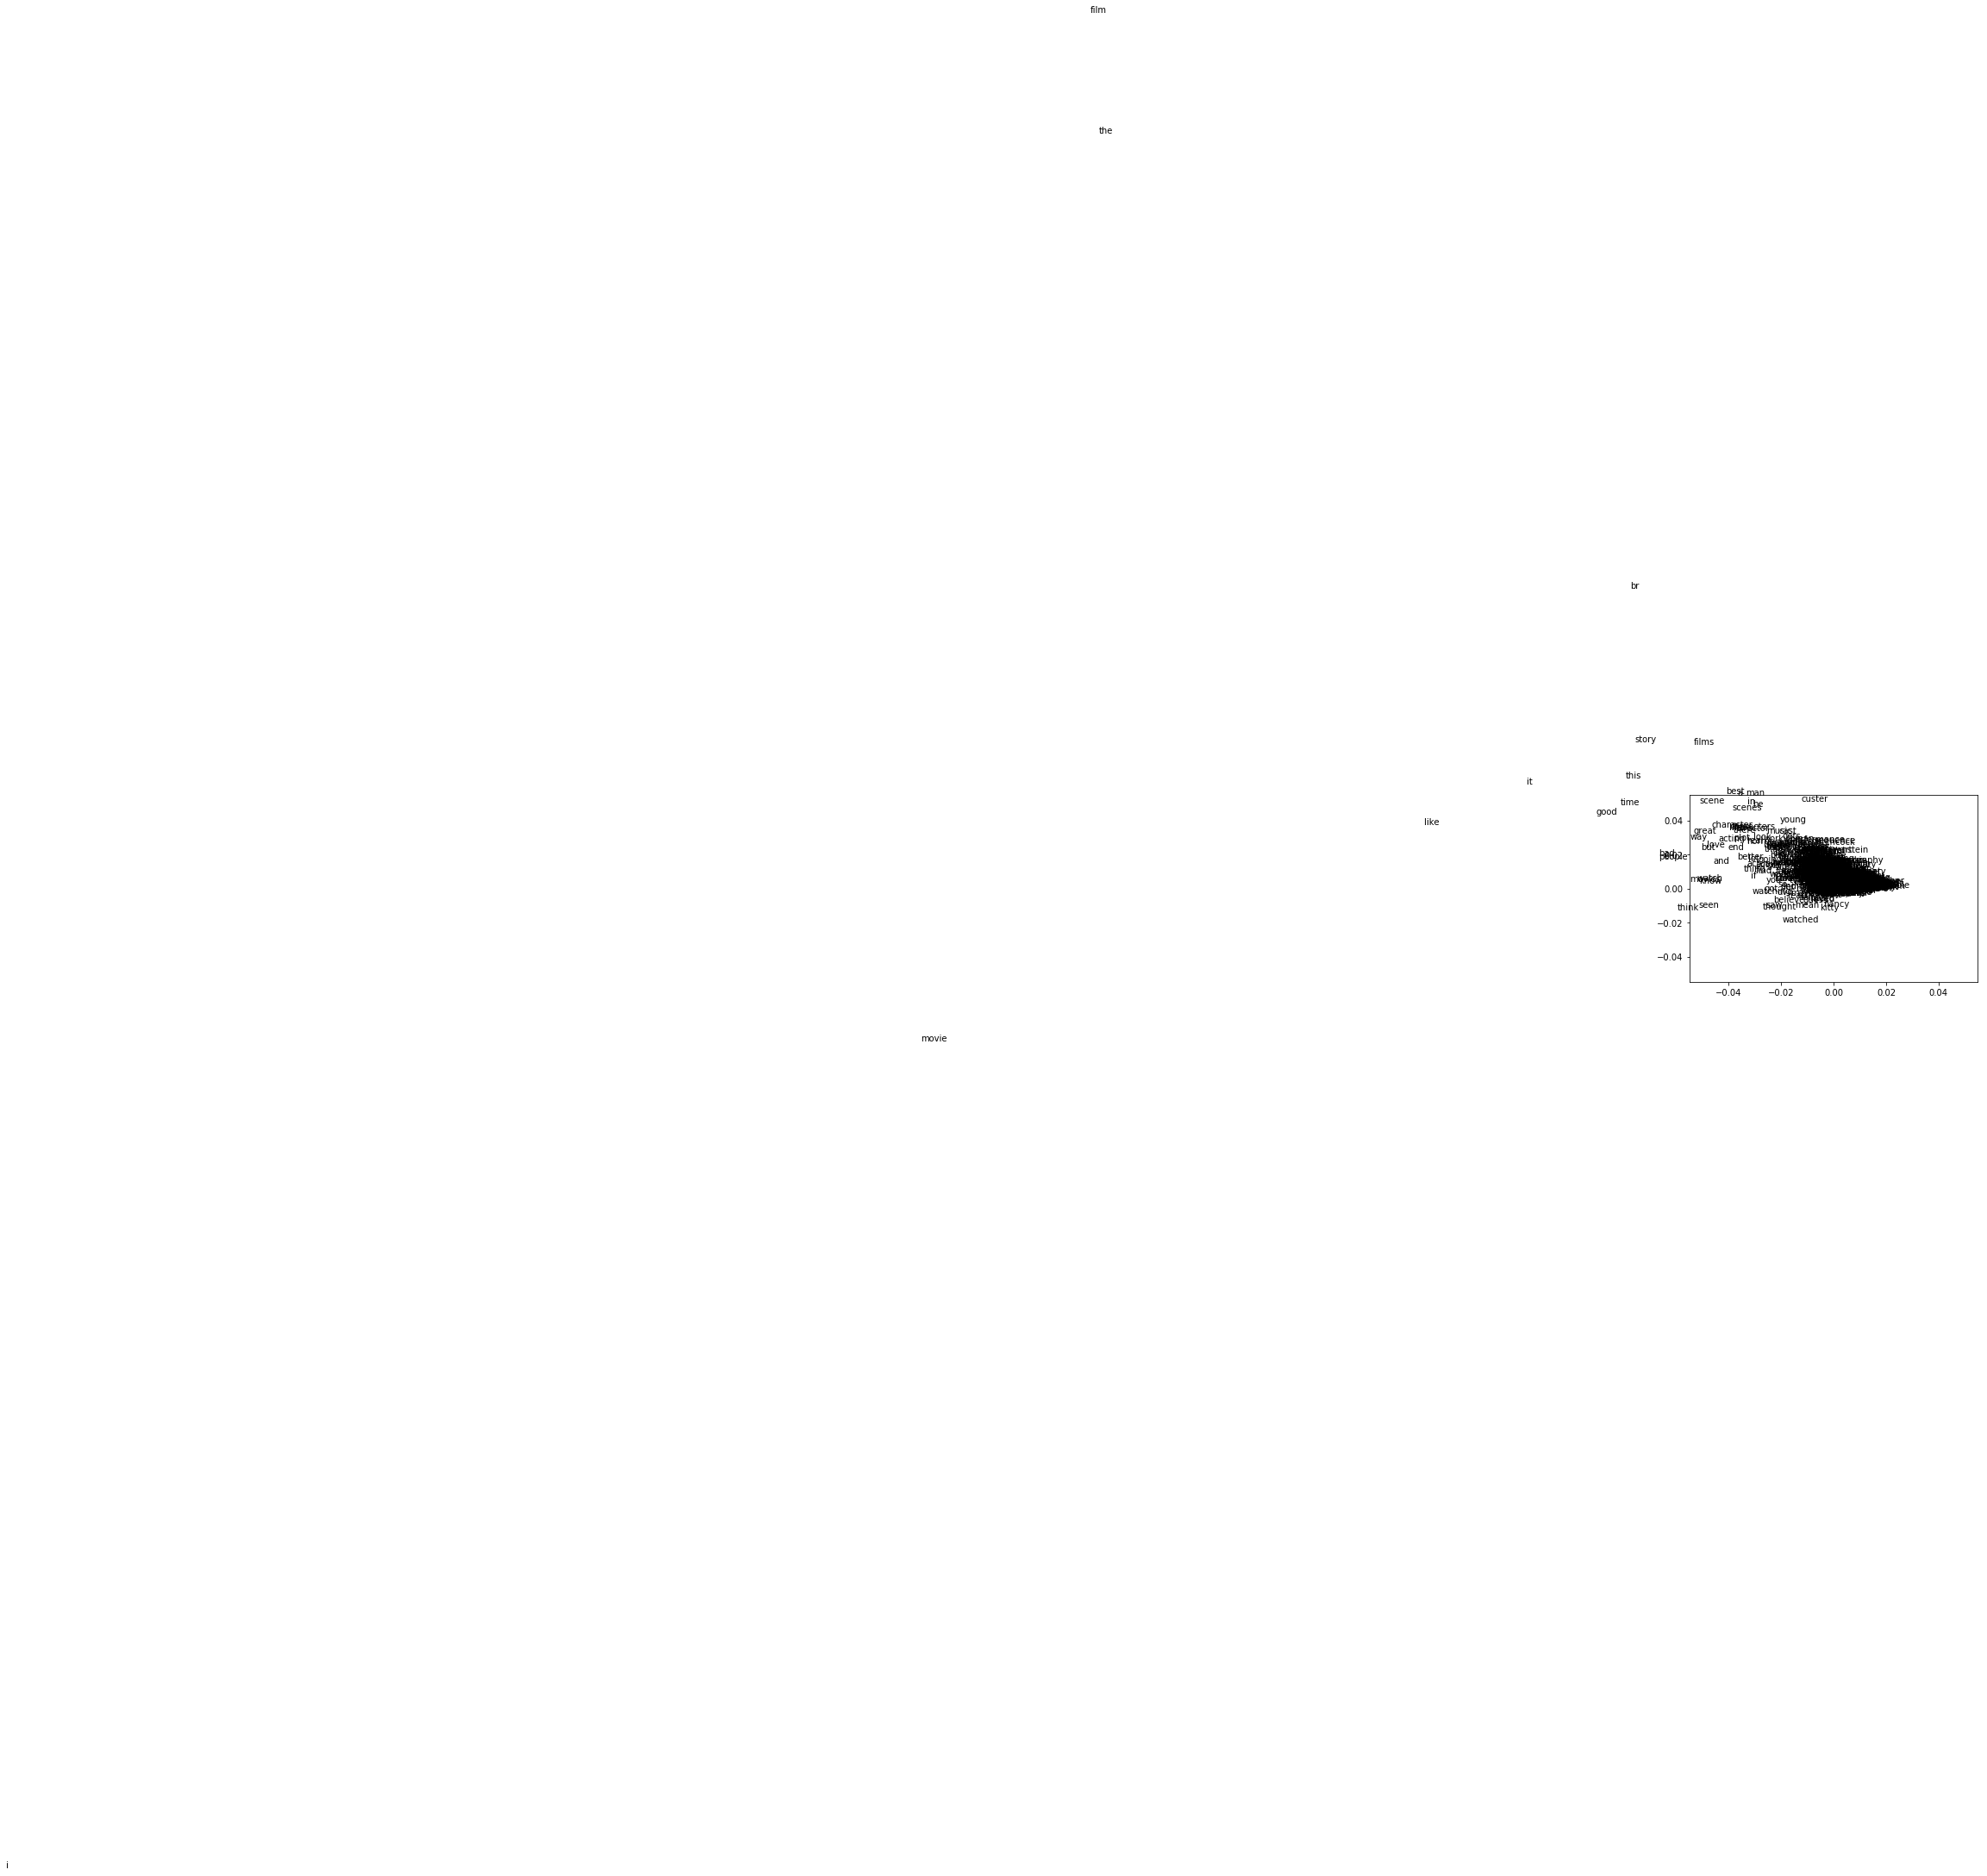

In [8]:
for i in range(l):
    plt.text(U[i, 0], U[i,1], dictionary[i])
    plt.axis('tight')

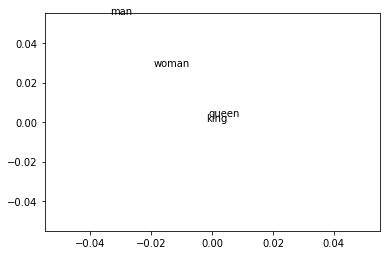

In [9]:
index = dictionary.doc2idx(['king', 'queen', 'man', 'woman'])

for j in index:
    plt.text(U[j, 0], U[j,1], dictionary[j])
    plt.axis('tight')